# 2023 AI/ML UnicornGym - Track 1

@jesamkim | 2023-Feb-08

# 3. 훈련 (xgboost)

### setup environment

In [1]:
%load_ext autoreload
%autoreload 2

# src 폴더 경로 설정
import sys
sys.path.append('./src')

In [2]:
import boto3
import sagemaker

In [3]:
%store -r project_prefix
%store -r bucket
%store -r input_data_uri

### SageMaker 세션과 Role, 사용 버킷 정의

In [4]:
sagemaker_session = sagemaker.session.Session()
role = sagemaker.get_execution_role()

role

'arn:aws:iam::376278017302:role/service-role/AmazonSageMaker-ExecutionRole-20230112T204234'

In [5]:
#bucket = sagemaker_session.default_bucket()

bucket

code_location = f's3://{bucket}/{project_prefix}/xgboost/code'
output_path = f's3://{bucket}/{project_prefix}/xgboost/output'

In [6]:
code_location

's3://sagemaker-us-east-1-376278017302/titanic-ml/xgboost/code'

In [7]:
output_path

's3://sagemaker-us-east-1-376278017302/titanic-ml/xgboost/output'

### 하이퍼파라미터 정의

In [8]:
hyperparameters = {
       "scale_pos_weight" : "19",    
        "max_depth": "2",
        "eta": "0.3",
        "objective": "binary:logistic",
        "num_round": "100",
#    "max_depth": "5",
#    "subsample": "0.7",
#    "gamma": "0",
#    "alpha": "0",
#    "lambda": "1"
}

### 훈련 실행 작업 정의

In [9]:
instance_count = 1
instance_type = "ml.m5.large"
# instance_type = "local"
max_run = 1*60*60

use_spot_instances = False
if use_spot_instances:
    max_wait = 1*60*60
else:
    max_wait = None

In [10]:
if instance_type in ['local', 'local_gpu']:
    from sagemaker.local import LocalSession
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
else:
    sagemaker_session = sagemaker.session.Session()

In [11]:
from sagemaker.xgboost.estimator import XGBoost

estimator = XGBoost(
    entry_point="xgboost_starter_script.py",
    source_dir="src",
    output_path=output_path,
    code_location=code_location,
    hyperparameters=hyperparameters,
    role=role,
    sagemaker_session=sagemaker_session,
    instance_count=instance_count,
    instance_type=instance_type,
    framework_version="1.3-1",
    max_run=max_run,
    use_spot_instances=use_spot_instances,  # spot instance 활용
    max_wait=max_wait,
)

### input_data_uri훈련 데이터셋 지정

In [12]:
input_data_uri

's3://sagemaker-us-east-1-376278017302/titanic-ml/input'

In [13]:
data_path=input_data_uri
!aws s3 sync ./dataset/ $data_path

upload: dataset/.ipynb_checkpoints/test-checkpoint.csv to s3://sagemaker-us-east-1-376278017302/titanic-ml/input/.ipynb_checkpoints/test-checkpoint.csv


In [14]:
if instance_type in ['local', 'local_gpu']:
    from pathlib import Path
    file_path = f'file://{Path.cwd()}'
    inputs = file_path.split('lab_1_training')[0] + 'dataset/'
    
else:
    inputs = data_path
inputs

's3://sagemaker-us-east-1-376278017302/titanic-ml/input'

### SageMaker Experiments 설정

In [15]:
# !pip install -U sagemaker-experiments

In [16]:
experiment_name='titanic-xgboost-test-1'

In [17]:
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from time import strftime

In [18]:
def create_experiment(experiment_name):
    try:
        sm_experiment = Experiment.load(experiment_name)
    except:
        sm_experiment = Experiment.create(experiment_name=experiment_name)

In [19]:
def create_trial(experiment_name):
    create_date = strftime("%m%d-%H%M%s")       
    sm_trial = Trial.create(trial_name=f'{experiment_name}-{create_date}',
                            experiment_name=experiment_name)

    job_name = f'{sm_trial.trial_name}'
    return job_name

### 훈련 실행

> 훈련하는 데이터(train.csv)에 String이 포함되어 있으면 Fail이 납니다. 앞에서 컬럼을 삭제하거나 숫자형으로 변환하는 등의 데이터 전처리 과정이 필요합니다.

In [20]:
create_experiment(experiment_name)
job_name = create_trial(experiment_name)

estimator.fit(inputs = {'inputdata': inputs},
                  job_name = job_name,
                  experiment_config={
                      'TrialName': job_name,
                      'TrialComponentDisplayName': job_name,
                  },
                  wait=False)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker:Creating training-job with name: titanic-xgboost-test-1-0207-13531675777997


In [21]:
estimator.logs()

2023-02-07 13:53:17 Starting - Starting the training job...
2023-02-07 13:53:33 Starting - Preparing the instances for training......
2023-02-07 13:54:30 Downloading - Downloading input data...
2023-02-07 13:55:09 Training - Downloading the training image...
2023-02-07 13:55:45 Training - Training image download completed. Training in progress...[2023-02-07 13:55:50.391 ip-10-2-95-132.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-02-07:13:55:50:INFO] Imported framework sagemaker_xgboost_container.training
[2023-02-07:13:55:50:INFO] No GPUs detected (normal if no gpus installed)
[2023-02-07:13:55:50:INFO] Invoking user training script.
[2023-02-07:13:55:50:INFO] Module xgboost_starter_script does not provide a setup.py. 
Generating setup.py
[2023-02-07:13:55:50:INFO] Generating setup.cfg
[2023-02-07:13:55:50:INFO] Generating MANIFEST.in
[2023-02-07:13:55:50:INFO] Installing module with the following command:
/miniconda3/bin/python3 -m pip install . 
Processi

### 실험 결과 보기

> 훈련 Job 시도에 대한 훈련 데이터, 모델 입력 하이퍼파라미터, 모델 평가 지표, 모델 아티펙트 결과 위치 등의 확인이 가능 합니다.

> 아래의 내용은 SageMaker Studio 에서 직관적으로 확인이 가능 합니다.

In [22]:
from sagemaker.analytics import ExperimentAnalytics
import pandas as pd
pd.options.display.max_columns = 50
pd.options.display.max_rows = 10
pd.options.display.max_colwidth = 100

In [23]:
trial_component_training_analytics = ExperimentAnalytics(
    sagemaker_session= sagemaker_session,
    experiment_name= experiment_name,
    sort_by="metrics.validation:auc.max",        
    sort_order="Descending",
    metric_names=["validation:auc"]
)

trial_component_training_analytics.dataframe()[['Experiments', 'Trials', 'validation:auc - Min', 'validation:auc - Max',
                                                'validation:auc - Avg', 'validation:auc - StdDev', 'validation:auc - Last', 
                                                'eta', 'max_depth', 'num_round', 'scale_pos_weight']]

,Experiments,Trials,validation:auc - Min,validation:auc - Max,validation:auc - Avg,validation:auc - StdDev,validation:auc - Last,eta,max_depth,num_round,scale_pos_weight
0,[titanic-xgboost-test-1],[titanic-xgboost-test-1-0207-13081675775298],0.85175,0.85175,0.85175,0.0,0.85175,"""0.3""","""2""","""100""","""19"""
1,[titanic-xgboost-test-1],[titanic-xgboost-test-1-0207-13531675777997],0.85175,0.85175,0.85175,0.0,0.85175,"""0.3""","""2""","""100""","""19"""
2,[titanic-xgboost-test-1],[titanic-xgboost-test-1-0207-13331675776789],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[titanic-xgboost-test-1],[titanic-xgboost-test-1-0207-12031675771401],NaN,NaN,NaN,NaN,NaN,"""0.3""","""2""","""100""","""19"""
4,[titanic-xgboost-test-1],[titanic-xgboost-test-1-0207-13401675777253],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,[titanic-xgboost-test-1],[titanic-xgboost-test-1-0207-11431675770235],NaN,NaN,NaN,NaN,NaN,NaN,"""5""",NaN,NaN
6,[titanic-xgboost-test-1],[titanic-xgboost-test-1-0207-11251675769119],NaN,NaN,NaN,NaN,NaN,"""0.3""","""2""","""100""","""19"""
7,[titanic-xgboost-test-1],[titanic-xgboost-test-1-0207-13221675776126],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,[titanic-xgboost-test-1],[titanic-xgboost-test-1-0207-12151675772149],NaN,NaN,NaN,NaN,NaN,"""0.3""","""2""","""100""","""19"""


### Evaluation 하기 

> SageMaker Processing을 이용하여 Evaluation을 수행하는 코드를 동작할 수 있습니다.

> MLOPs에서 Processing을 적용하면 전처리, Evaluation 등을 serverless로 동작할 수 있습니다.

In [24]:
from sagemaker.processing import FrameworkProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

In [25]:
instance_count = 1
instance_type = "ml.m5.large"
# instance_type = 'local'

In [26]:
script_eval = FrameworkProcessor(
    XGBoost,
    framework_version="1.3-1",
    role=role,
    instance_type=instance_type,
    instance_count=instance_count
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.m5.large.


In [27]:
artifacts_dir = estimator.model_data

In [28]:
s3_test_path = data_path + '/test.csv'
detect_outputpath = f's3://{bucket}/xgboost/processing'

In [29]:
source_dir='src'

if instance_type == 'local':
    from sagemaker.local import LocalSession
    from pathlib import Path

    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    source_dir = f'{Path.cwd()}/src'
    s3_test_path=f'./dataset/test.csv'

In [30]:
create_experiment(experiment_name)
job_name = create_trial(experiment_name)

script_eval.run(
    code="evaluation.py",
    source_dir=source_dir,
    inputs=[ProcessingInput(source=s3_test_path, input_name="test_data", destination="/opt/ml/processing/test"),
            ProcessingInput(source=artifacts_dir, input_name="model_weight", destination="/opt/ml/processing/model")
    ],
    outputs=[
        ProcessingOutput(source="/opt/ml/processing/output", output_name='evaluation', destination=detect_outputpath + "/" + job_name),
    ],
    job_name=job_name,
    experiment_config={
        'TrialName': job_name,
        'TrialComponentDisplayName': job_name,
    },
    wait=False
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.processing:Uploaded src to s3://sagemaker-us-east-1-376278017302/titanic-xgboost-test-1-0207-13571675778239/source/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-us-east-1-376278017302/titanic-xgboost-test-1-0207-13571675778239/source/runproc.sh
INFO:sagemaker:Creating processing-job with name titanic-xgboost-test-1-0207-13571675778239


In [31]:
script_eval.latest_job.wait()

............................Requirement already satisfied: xgboost in /miniconda3/lib/python3.7/site-packages (1.3.3)
[notice] A new release of pip available: 22.2.2 -> 23.0
[notice] To update, run: pip install --upgrade pip
#############################################
args.model_path: /opt/ml/processing/model/model.tar.gz
args.test_path: /opt/ml/processing/test/test.csv
args.output_evaluation_dir: /opt/ml/processing/output
****** All folder and files under /opt/ml/processing ****** 
('/opt/ml/processing', ['input', 'output', 'test', 'model'], [])
('/opt/ml/processing/input', ['code', 'entrypoint'], [])
('/opt/ml/processing/input/code', ['__pycache__', '.ipynb_checkpoints'], ['xgboost_starter_script.py', 'sourcedir.tar.gz', 'evaluation.py', 'eda_utils.py'])
('/opt/ml/processing/input/code/__pycache__', [], ['eda_utils.cpython-310.pyc'])
('/opt/ml/processing/input/code/.ipynb_checkpoints', [], ['xgboost_starter_script-checkpoint.py', 'evaluation-checkpoint.py', 'eda_utils-checkpoint.py

### 실험 결과 확인

In [32]:
artifacts_dir = estimator.model_data.replace('model.tar.gz', '')
print(artifacts_dir)
!aws s3 ls --human-readable {artifacts_dir}

s3://sagemaker-us-east-1-376278017302/titanic-ml/xgboost/output/titanic-xgboost-test-1-0207-13531675777997/output/
2023-02-07 13:56:10    2.1 KiB model.tar.gz
2023-02-07 13:56:10  185 Bytes output.tar.gz


In [33]:
model_dir = './model'

!rm -rf $model_dir

import json , os

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

!aws s3 cp {artifacts_dir}model.tar.gz {model_dir}/model.tar.gz
!tar -xvzf {model_dir}/model.tar.gz -C {model_dir}

download: s3://sagemaker-us-east-1-376278017302/titanic-ml/xgboost/output/titanic-xgboost-test-1-0207-13531675777997/output/model.tar.gz to model/model.tar.gz
xgboost-model


In [34]:
#!pip install xgboost graphviz

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 10.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 15.9 MB/s eta 0:00:00


In [35]:
import xgboost as xgb
import matplotlib.pyplot as plt

In [36]:
model = xgb.XGBClassifier()
model.load_model("./model/xgboost-model")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

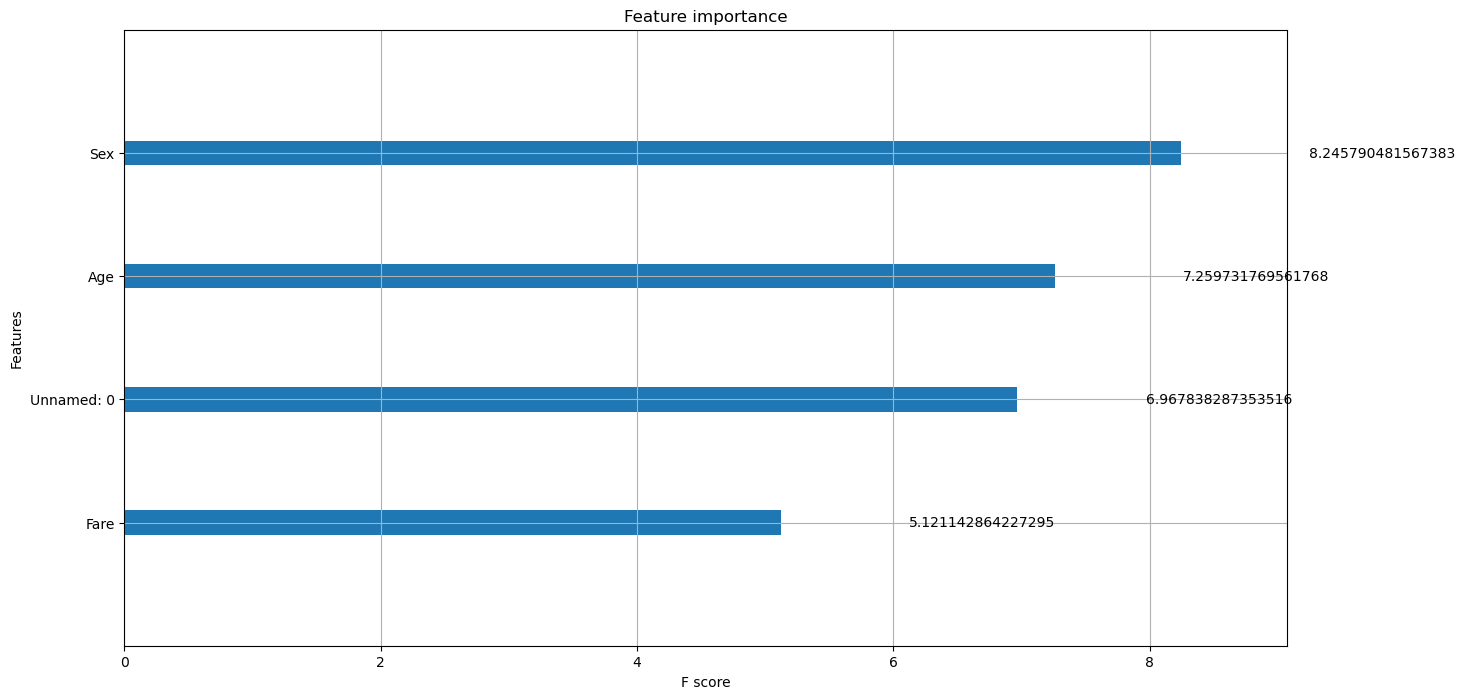

In [40]:
test_prep_df = pd.read_csv('./dataset/test.csv') 
feature_data = xgb.DMatrix(x_test)
model.get_booster().feature_names = feature_data.feature_names
model.get_booster().feature_types = feature_data.feature_types
fig, ax = plt.subplots(figsize=(15, 8))
xgb.plot_importance(model, ax=ax, importance_type='gain')